In [1]:
from inference_utils import *
import numpy as np
import matplotlib.pyplot as plt
import io
from matplotlib.pyplot import figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from PIL import Image
import xml.etree.ElementTree as ET
from PIL import Image

In [2]:
def getBBox(img_id):
    xml_filePath = os.path.join (annotation_dir, img_id + '.xml')
    xml_file = open(xml_filePath, encoding='UTF-8')
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls = obj.find('name').text
        bboxes = []
        if cls != 'HUMAN':
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)
            single_box = {
                    'xmin':xmin,
                    'xmax':xmax,
                    'ymin':ymin,
                    'ymax':ymax,
            }
            bboxes.append(single_box)
    return bboxes

In [3]:
def normalize_tensor(vector):

    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        vector -= min_v
        vector = vector / range_v
    else:
        vector = torch.zeros(vector.size())

    return vector

In [4]:
def renderFeatureMap(pxl_lvl_anom_score,sample_img):
    score_range = pxl_lvl_anom_score.min(), pxl_lvl_anom_score.max()
    fmap_img = pred_to_img(pxl_lvl_anom_score, score_range)
    
    figure(figsize=(10, 10), dpi=200)
    plt.imshow(sample_img)
    plt.imshow(fmap_img, cmap="jet", alpha=0.5)
    plt.axis('off');
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    overlay_img = Image.open(buf)
    plt.clf()
    return np.array(overlay_img)

                

In [5]:
def get_all_fv_imgs(img_id, runs_dir, obj_dir):
    img_id = random.choice(os.listdir(runs_dir))
    run_path = os.path.join(runs_dir, img_id)

    sample_img_path = os.path.join(obj_dir, img_id + '.jpg')
    sample_img = cv2.imread(sample_img_path)

    all_fv_imgs = []
    information = []
    for json_file_name in os.listdir(run_path):
        if '.json' in json_file_name:
            json_file_path = os.path.join(run_path, json_file_name)

            with open(json_file_path) as json_file: result_data = json.load(json_file)
            
            all_fv_imgs.append(renderFeatureMap(torch.tensor(result_data['pixel_score']), sample_img))
            information.append(result_data['count_pixels'])
    return all_fv_imgs, information


In [6]:
import cv2
runs_dir = '/Users/rc/Documents/GitHub/my_patchcore/FinalCore/exp/2022_07_21_13_18_01/runs'
img_id = random.choice(os.listdir(runs_dir))
obj_dir = '/Users/rc/Documents/GitHub/my_patchcore/datasets/full_body/test/objs/'
all_fv_imgs, information = get_all_fv_imgs(img_id, runs_dir, obj_dir)

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

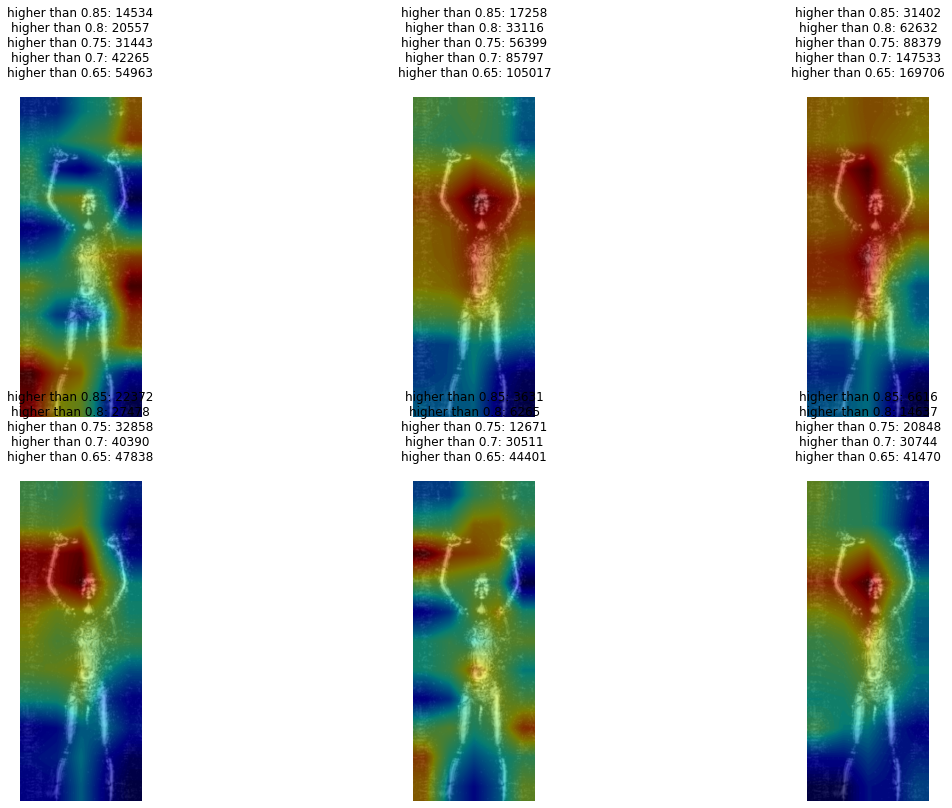

In [12]:
# setting values to rows and column variables
rows = 3
columns = 3
fig = plt.figure(figsize=(20, 20))
for idx, img in enumerate(all_fv_imgs):
    fig.add_subplot(rows, columns, idx+1)
    # showing image
    plt.imshow(img)
    plt.axis('off')
    info =''
    for th in ['0.85', '0.8', '0.75', '0.7', '0.65']:
        info += 'higher than {}: {}\n'.format(th,information[idx][th])
    plt.title(info)